# Shor's algorithm

Shor's algorithm, named after mathematician Peter Shor, is a quantum algorithm (an algorithm that runs on a quantum computer) for integer factorization, formulated in 1994. Informally, it solves the following problem: Given an integer **N**, find its prime factors.

## Overview

*Lemma*: Factoring is equivalent to finding a nontrivial squareroot of 1 mod N.

**Complexity:**

- Complexity on quantum computer: 
![quantum_complexity](https://wikimedia.org/api/rest_v1/media/math/render/svg/41344b55ef5e6494bb835b1adde9a4be4403303c)

- Complexity on classical computer:
![classical_complexity](https://wikimedia.org/api/rest_v1/media/math/render/svg/1956460a1cea4f2794fa0487f886e2a64cedc244)

![complexity_graph](https://dal.objectstorage.open.softlayer.com/v1/AUTH_039c3bf6e6e54d76b8e66152e2f87877/images-classroom/shor-figure1l0qpbqeb138fr.png)

**Steps:**

- 2001 ==> *IBM factored 15 using 7 qubits*
- 2012 ==> *15 factorized with solid-state qubits and 21 factorized*
- 2012 ==> *143 factorized using adiabatic quantum computation (rather than Shor's algorithm)*
- 2014 ==> *adiabatic quantum computation factorized 56153*

### Premise
#### Two problems coming from the quantum theory
- Measurement: the state of a q-qubit quantum register is described by a vector of dimension 2^q, exponentially larger than the dimension of the vector required to describe q classical bits. However, there is a catch: in a classical computer we can simply read the state of the bits, whereas in a quantum computer we do not have direct, unrestricted access to the quantum state. Information on the quantum state are obtained by applying a measurement gate, after which the original quantum state is no longer available, since it collapses to a linear combination of only those basis states that are consistent with the outcome of the measurement.

- No cloning theorem: since measurement destroys the quantum state, it is natural to look for a way to create a copy of a quantum state, so that we can apply a measurement gate on it, leaving the original state untouched. Unfortunately, cloning is impossible. This is due to the fact that gates are unitary matrix [proof].

## Structure of the algorithm

![process](https://algassert.com/assets/2017-08-28-shor-algorithm/flowchart.png)

Shor's algorithm consists of two parts:

**1) [CLASSICAL PART]** A reduction, which can be done on a classical computer, of the factoring problem to the problem of order-finding.

**2) [QUANTUM PART]** A quantum algorithm to solve the order-finding problem.


Shor's algorithm hinges on a result from number theory. This result is:

*The function $ \mathcal {F}$(a) = x^a mod n is a periodic function, where x is an integer coprime to n. In the context of Shor's algorithm n will be the number we wish to factor. When two numbers are coprime it means that their greatest common divisor is 1.*

The reason why this function is of utility in factoring large numbers is the following:

since $ \mathcal {F}$(a) is a periodic function, it has some period r. We know that $x^0 \ mod \ n = 1$, so $x^r \ mod \ n = 1$, and $x^{2r} \ mod \ n = 1$ and so on since the function is periodic.

![algebraic_manipulation](http://mathurl.com/y7xnrfh8.png)

And if r is an even number:

![even_number](http://mathurl.com/y9xnja7t.png)

This means that the product $(x^{r/2} -1)(x^{r/2} + 1)$ is an integer multiple of n, the number to be factored. So long as $x^{r/2}$ is not equal to $ \pm 1$, then at least one of $(x^{r/2} - 1)$ or $(x^{r/2} + 1)$ must have a nontrivial factor in common with n. So by computing $gcd(x^{r/2} - 1, n)$, and $gcd(x^{r/2} + 1, n)$, we will obtain a factor of n, where gcd is the greatest common denominator function.

### Example

Let's see all of this with an example:

Let N = 21 the number we want to factor. The key is to solve this equation:

${x^2 \equiv 1 \ (mod \ 21)}$

Of course the trivial answer is ${x = 1}$.<br>
Also ${x = -1}$ is fine, because:<br><br> 
${-1 \equiv 20 \ (mod \ 21)}$<br>
${(-1)^2 \equiv 400 \ (mod \ 21)}$<br>
${(-1)^2 \equiv 1 \ (mod \ 21)}$

But there's more...

${x = 8}$<br>
${x^2 = 64 \ (mod \ 21) \equiv 1 \ (mod \ 21)}$

So ${8^2 \equiv 1 \ (mod \ 21)}$<br>
${8^2 - 1 \equiv 0 \ (mod \ 21)}$

21 divides (8+1)(8-1), but does not divide neither of these. However 21 = 3 x 7 and as we can see 3 divides (8+1) and 7 divides (8-1).<br>
So we can recover the prime factors by computing<br>
gcd(21, 8+1) = 3
gcd(21, 8-1) = 7

Ok, but maybe we've been lucky with x = 8. What about x = -8?

${x = -8 \equiv 13 \ (mod \ 21)}$<br>
${13^2 \equiv 169 \equiv 1 \ (mod \ 21)}$

Another nontrivial squareroot!

If we can find ${x}$ s.t. ${x \not\equiv \pm 1 \ (mod \ N)}$ but ${x^2 \equiv 1 \ (mod \ N)}$, then we know that N divides ${(x+1)(x-1)}$ and since ${x \pm 1 \not\equiv 0 \ (mod \ N)}$ N does not divide ${(x \pm 1)}$.<br>
This is possible only if some of the factors of N divide ${(x+1)}$ and others divide ${(x-1)}$.

How do we discover these nontrivial squareroots?

N = 21<br>
x = 2

${2^0 \equiv 1 \ (mod \ 21)}$<br>
${2^1 \equiv 2 \ (mod \ 21)}$<br>
${2^2 \equiv 4 \ (mod \ 21)}$<br>
${2^3 \equiv 8 \ (mod \ 21)}$<br>
${2^4 \equiv 16 \ (mod \ 21)}$<br>
${2^5 \equiv 11 \ (mod \ 21)}$<br>
${2^6 \equiv 1 \ (mod \ 21)}$ ${\implies}$ ${2^6 = (2^3)^2 \equiv 1 \ (mod \ 21)}$<br>
Where ${2^3 = 8}$

In general we pick ${x}$ at random and we compute ${x^0, x^1, ... , x^r \equiv 1 \ (mod \ N)}$<br>
and if we are lucky ${\implies}$ r is even, so we can write ${(x^{r/2})^2 \equiv 1 \ (mod \ N)}$<br>
and if we are even luckier ${\implies x^{r/2} \not\equiv \pm 1 \ (mod \ N)}$ 

Lucky is a bit too general...Fortunately there's a lemma which says the following:<br>
**Lemma:** *Let N be an odd composite, with at least two distinct prime factors, and let x be uniformly random between 0 and N-1. if GCD(x, N) = 1, then with probability at least 1/2, the order r of x (mod N) is even, and x^r/2 is a nontrivial square root of 1 (mod N).*

But why is this good for a quantum algorithm?<br>
The problem is that the number of steps after which the sequence starts repeating itself could be almost as large as n (in RSA n is a very big number!)
<table style="border-collapse:collapse;border-spacing:0" class="tg"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">a</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">f(a) = x^a (mod N)</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">0</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">1</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">1</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">2</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">2</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">4</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">3</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">8</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">4</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">16</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">5</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">11</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">6</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">1</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">7</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">2</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">8</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">4</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">9</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">16</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">10</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">11</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">11</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">1</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">12</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:4px 20px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:left;vertical-align:top">2</td></tr></table>

Once we have this table, the algorithm creates a superposition ${\frac{1}{\sqrt{M}} \sum_{a=0}^{M-1}}$ of the rows of the table.

Then what we do is **period finding**: we measure the second register and we see some value ${f(a)}$ and so every place where we have ${f(a)}$ collapse and now the first register is a (periodic) superposition. Next step is sampling on the first register and we can do this classically in an efficient way, obtaining r.

## Quantum Fourier Transform

The quantum Fourier transform (for short: QFT) is a linear transformation on quantum bits, and is the quantum analogue of the discrete Fourier transform. 

Like the classical Fourier transform, quantum Fourier transform (QFT) takes data from the original signal representation to the frequency domain representation. The QFT differs from the classical Fourier transform in that it operates on a superposition state and produces a different superposition state as the output.

The quantum Fourier transform can be performed efficiently on a quantum computer, with a particular decomposition into a product of simpler unitary matrices. Using a simple decomposition, the discrete Fourier transform on ${\displaystyle 2^{n}}$ amplitudes can be implemented as a quantum circuit consisting of only ${\displaystyle O(n^{2})}$ Hadamard gates and controlled phase shift gates, where ${\displaystyle n}$ is the number of qubits. This can be compared with the classical discrete Fourier transform, which takes ${\displaystyle O(n2^{n})}$ gates (where ${\displaystyle n}$ is the number of bits), which is exponentially more than ${\displaystyle O(n^{2})}$. However, the quantum Fourier transform acts on a quantum state, whereas the classical Fourier transform acts on a vector, so not every task that uses the classical Fourier transform can take advantage of this exponential speedup.

${x = cos\theta_1 + isin\theta_1 = e^{i\theta_1}}$
${y = cos\theta_2 + isin\theta_2 = e^{i\theta_2}}$

${x \cdot y = (cos\theta_1 + isin\theta_1)(cos\theta_2 + isin\theta_2) = cos(\theta_1 + \theta_2) + isin(\theta_1 + \theta_2) = e^{i(\theta_1 + \theta_2)}}$

The interesting part here is that when we multiply the two complex numbers, their angles add up.

If we consider the n-th roots of unity, i.e. the n complex solutions of ${x^n = 1}$:

<img src="https://cdn-images-1.medium.com/max/1600/0*9LFiRIrkh4n6XPLA.png" style="width: 500px; height: 320px"/>

Since the unit vectors which represent these complex numbers are pointing out in all directions, if we add them up they'll cancel out completely:<br>
${1 + \omega + \omega^2 + ... + \omega^{n-1} = 0}$

More generally: <br>
${1 + \omega^j + \omega^{2j} + ... + \omega^{{(n-1)}j} = 0 \ if \ j \neq 0, \ n \ if \ j = 0}$

<center>
$
\frac{1}{\sqrt{N}}
\begin{bmatrix}
    1 & 1 & 1 & 1 & \dots & 1 \\
    1 & \omega & \omega^2 & \omega^3 & \dots & \omega^{N-1} \\
    1 & \omega^2 & \omega^3 & \omega^4 & \dots & \omega^{2(N-1)} \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & \omega^{N-1} & \omega^{2(N-1)} & \omega^{3(N-1)} & \dots & \omega^{(N-1)^2}
\end{bmatrix}
$
</center>

This above is the Quantum Fourier Transform operator, whose entries are the n-th roots of unity.

Of course it can be rewritten in the form:
<img src="https://cdn-images-1.medium.com/max/1600/1*wnG7S79eDr-X66uSbDiSww.gif" style="width: 600px; height: 200px"/><br>

Let's see an example for N = 4:

$
QFT_4 = \frac{1}{2}
\begin{bmatrix}
    1 & 1 & 1 & 1 \\
    1 & i & -1 & -i \\
    1 & -1 & 1 & -1 \\
    1 & -i & -1 & i
\end{bmatrix}
$

If we apply it to a state:

$
\frac{1}{2}
\begin{bmatrix}
    1 & 1 & 1 & 1 \\
    1 & i & -1 & -i \\
    1 & -1 & 1 & -1 \\
    1 & -i & -1 & i
\end{bmatrix}
\begin{bmatrix}
    \alpha_0 \\
    \alpha_1 \\
    \alpha_2 \\
    \alpha_3
\end{bmatrix}
=
\begin{bmatrix}
    \beta_0 \\
    \beta_1 \\
    \beta_2 \\
    \beta_3
\end{bmatrix}
$

In braket notation:

${\alpha_0|0\rangle + \alpha_1|1\rangle + \alpha_2|2\rangle + \alpha_3|3\rangle}$

${|2\rangle \xrightarrow{QTF_4} \frac{1}{2}|0\rangle - \frac{1}{2}|1\rangle + \frac{1}{2}|2\rangle - \frac{1}{2}|3\rangle}$ since we're considering the third column.

The crucial point for our purposes is that QFT has two nice properties:

#### 1) Convolution-Multiplication

$
QFT_N = \frac{1}{\sqrt{N}}
\begin{bmatrix}
    1 & 1 & 1 & 1 & \dots & 1 \\
    1 & \omega & \omega^2 & \omega^3 & \dots & \omega^{N-1} \\
    1 & \omega^2 & \omega^3 & \omega^4 & \dots & \omega^{2(N-1)} \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & \omega^{N-1} & \omega^{2(N-1)} & \omega^{3(N-1)} & \dots & \omega^{(N-1)^2}
\end{bmatrix}
\begin{bmatrix}
    \alpha_0 \\
    \alpha_1 \\
    \alpha_2 \\
    \vdots \\
    \alpha_{N-1}
\end{bmatrix}
=
\begin{bmatrix}
    \beta_0 \\
    \beta_1 \\
    \beta_2 \\
    \vdots \\
    \beta_{N-1}
\end{bmatrix}
$
MEASURE ${\implies}$ see j w.p. ${|\beta_j|^2}$

$
QFT_N = \frac{1}{\sqrt{N}}
\begin{bmatrix}
    1 & 1 & 1 & 1 & \dots & 1 \\
    1 & \omega & \omega^2 & \omega^3 & \dots & \omega^{N-1} \\
    1 & \omega^2 & \omega^3 & \omega^4 & \dots & \omega^{2(N-1)} \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & \omega^{N-1} & \omega^{2(N-1)} & \omega^{3(N-1)} & \dots & \omega^{(N-1)^2}
\end{bmatrix}
\begin{bmatrix}
    \alpha_N \\
    \alpha_0 \\
    \alpha_1 \\
    \vdots \\
    \alpha_{N-1}
\end{bmatrix}
=
\begin{bmatrix}
    \beta_0 \\
    \omega\beta_1 \\
    \omega^2\beta_2 \\
    \vdots \\
    \omega^{N-1}\beta_{N-1}
\end{bmatrix}
$
MEASURE ${\implies}$ see j w.p. ${|\beta_j|^2}$

This means that any way you shift the input superposition is not going to make any difference to the output probabililty distribution.

#### 2) Periodic Function

$
\begin{bmatrix}
    \alpha_0 \\
    \alpha_1 \\
    \alpha_2 \\
    \vdots \\
    \alpha_{r-1} \\
    \vdots \\
    \alpha_0 \\
    \alpha_1 \\
    \alpha_2 \\
    \vdots \\
    \alpha_{r-1}
\end{bmatrix}
$
${\xrightarrow{QFT_M}}$
$
\begin{bmatrix}
    \beta_0 \\
    \beta_1 \\
    \beta_2 \\
    \vdots \\
    \beta_{\frac{M}{r}} \\
    \vdots \\
    \beta_0 \\
    \beta_1 \\
    \beta_2 \\
    \vdots \\
    \beta_{\frac{M}{r}}
\end{bmatrix}
$

Let's consider a special case where ${\alpha_j}$ is periodic with period ${r}$ but it has non-zero values only in $0, r, 2r, ... , M-r$.<br>
If we apply ${QFT_M}$:

$
\sqrt{\frac{r}{M}}
\begin{bmatrix}
    1 \\
    0 \\
    \vdots \\
    0 \\
    1 \\
    0 \\
    \vdots \\
    0 \\
    1 \\
    0 \\
    \vdots
\end{bmatrix}
$
$\xrightarrow{QFT_M}$
$
\frac{1}{\sqrt{r}}
\begin{bmatrix}
    1 \\
    0 \\
    \vdots \\
    0 \\
    1 \\
    0 \\
    \vdots \\
    0 \\
    1 \\
    0 \\
    \vdots
\end{bmatrix}
$

Which in kat notation is 

$\large{\sqrt{\frac{r}{M}} \sum_{j=0}^{\frac{M}{r}-1} |jr\rangle \xrightarrow{QFT} \sum_{j=0}^{M-1} \beta_j|j\rangle}$

Let's figure out what ${\beta_j}$ looks like when $j$ is a multiple of $\frac{M}{r}$

$\large\beta_{k\frac{M}{r}} = \sum_{j=0}^{\frac{M}{r}-1} \sqrt{\frac{r}{M}} \cdot \frac{1}{\sqrt{M}} \cdot \omega^{jr \cdot k\frac{M}{r}}$

As we can see the $r$ can be simplified and we obtain $\omega$ to some multiple of $M$, but $\omega^M = 1$, so...

$ \dots = \large\frac{M}{r} \cdot \frac{\sqrt{r}}{M} = \frac{1}{\sqrt{r}}$

The phase keep precessing at some rate proportional to the coefficient we're looking at, which is $\frac{kM}{r}$. So what we're doing is applying QFT to a periodic function and the period is such that every time we pick up the phase, the phase is exactly 1, so we have constructive interference.<br>
But how many such multiples of $\frac{M}{r}$ are there? Exactly $r$, so the rest of the components $\beta_j$ where $j$ is not a multiple of $\frac{M}{r}$ must be zero.

And what is $\beta_j$ for $j$ not a multiple of $\frac{M}{r}$?<br>
In this case the phase will not cancel out: it keeps precessing being simmetrically distributed around the circle and so when you add up all the vectors you get zero, destructive interference, and so $\beta_j = 0$.

## Period Finding

**input:** $f: {0,1,...,M-1} \xrightarrow S$, such that for all $x, \ f(x) = f(x+r)$.<br>
**challenge:** find $r$

Let's suppose that $M$ is a 1000 digit number ($M \sim 10^{1000}$)<br>
$r \sim \sqrt{M}$, so $r \sim 500$ digit number

Classically all you can do is picking inputs until you see a collision, i.e. two different numbers $x,\ y \ s.t. \ f(x) = f(y)$.<br>
But how long does it take before you get to see a collision?

**Birthday Paradox** $\implies \sqrt{r}$ inputs suffice to see a collision.<br>
However, still $\sqrt{r} \sim 250$ digit number, so $\sqrt{r} \sim 10^{250}$, impossible classically.

Quantum solution:

<img src="https://i.ibb.co/VYXbTcQ/periodfinding.png" style="width: 290px; height: 190px"/>

We set uniform superposition on $|x\rangle$, and the output will be:

$\large\frac{1}{\sqrt{M}} \sum_{x=0}^{M-1} |x\rangle|f(x)\rangle \xrightarrow{measure} \sum_{x=0}^{M-1} \alpha_x |x\rangle$

Now we measure $|f(x)\rangle$, obtaining $f(a)$ for some $a$, e.g. $f(a) = 4$.<br>
There are many values of $x$ that give $f(a) = 4$.<br>
The property of these values is that they are equally far apart each other.

<img src="https://i.ibb.co/MDPH4X2/IMG-0326.jpg" style="width: 300px; height: 100px"/>

What we can do now is Fourier sampling, taking advantage from the following property: if we shift the input superposition the output of Fourier sampling does not change (see above QFT).

<img src="https://i.ibb.co/9gNLh7t/IMG-0327.jpg" style="width: 300px; height: 100px"/>

This is good because now we have a periodic superposition where the non-zero amplitudes are exactly the multiples of the period.

$\sqrt{\frac{r}{M}} \sum_{j=0}^{\frac{M}{r}-1} |jr\rangle$

and the output will be a multiple of $\frac{M}{r}$.<br>
Running this a few times we will obtain these multiples of $\frac{M}{r}$, so $gcd(m1,m2) = \frac{M}{r}$, and knowing $M \implies r$.

### CLASSICAL PART

In [25]:
import math
import random
import sys
from fractions import Fraction
from builtins import input

def shor(N, attempts = 1):
    
    # build compilation engine list
    rule_set = DecompositionRuleSet(modules=[projectq.libs.math,
                                             projectq.setups.decompositions])
    compilerengines = [AutoReplacer(rule_set),
                       InstructionFilter(high_level_gates),
                       TagRemover(),
                       LocalOptimizer(3),
                       AutoReplacer(rule_set),
                       TagRemover(),
                       LocalOptimizer(3)]

    # make the compiler and run the circuit on the simulator backend
    eng = MainEngine(Simulator(), compilerengines)
    
    for attempt in range(attempts):
        print("-----------------------------------")
        print("\nAttempt #" + str(attempt))
        
        x = random.randint(0, N)
        print("Random x between 0 and N-1 --> ", str(x))
        
        '''If the GCD is not 1, x is a nontrivial factor of N, so we're done'''
        if (math.gcd(x, N) != 1):
            print("\nFactors found classically, re-attempt...")
            continue
        
        '''Otherwise it means that x and N are coprime
        Here the quantum part starts: Shor's algorithm tries to find r, the period of x^a mod n, where n is 
        the number to be factored and x is an integer coprime to n.
        It is important to underline the r  is the smallest positive integer such that x^r = 1 mod N
        '''
        r = find_period(eng, N, x, verbose=False)
        
        '''If r is odd or if x^r/2 = -1 (mod N), choose another x
        EXPLANATION: we already know that x^r/2 is NOT congruent to 1 (mod N), otherwise the order of x would be r/2,
        instead of r. So we have to check only that x^r/2 is NOT congruent to -1 (mod N)
        '''
        if ((r % 2 != 0) or (pow(x, int(r/2), N) == -1)): 
            print("r is odd or x^r/2 = -1 (mod N), re-attempt...")
            continue
            
        print("\nPeriod found: " + str(r))
        
        p = math.gcd(x**int(r / 2) + 1, N)
        q = math.gcd(x**int(r / 2) - 1, N)
        
        if ((not p * q == N) and p * q > 1 and int(1. * N / (p * q)) * p * q == N):
            p, q = p * q, int(N / (p * q))
        if p * q == N and p > 1 and q > 1:
            print("\nFactors found: {} * {} = {}.".format(p, q, N))
            break
        else:
            print("\nBad luck: Found {} and {}".format(p, q))

### Phases:

The Shor algorithm requires two quantum registers. At the beginning of the algorithm, one has to choose **q = 2^s** for some integer **s** such that **n^2 ≤ q < 2n^2**, where n is to be factored. More precisely, it proceeds as follows:

**1)** Create a quantum register and partition it into two parts, register 1 and register 2. Thus the state of our quantum computer is given by: |reg1, reg2>. 

Register 1 must have enough qubits to represent the integers as large as q - 1, while register 2 must have enough qubits to represent integers as large as n - 1 (the calculation for how many qubits are needed would be done on a classical computer).

**2)** Initialization: put register-1 in the uniform superposition, i.e. an equally weighted superposition of all integers from 0 to q - 1 (a superposition of the all the rows of the table shown above), and load register 2 with all zeros.

![state0](http://mathurl.com/y7gqualj.png)

**3)** Now apply the transformation $x^a \ mod \ n$ to for each number stored in register 1 and store the result in register 2.
The new state is:

![state1](http://mathurl.com/y8e6atxu.png)


#### *Modular Exponentiation*
The bottleneck in the quantum factoring algorithm is modular exponentiation. The modular exponentiation problem, given n, x and r, find ${x^r \ (mod \ n)}$. Fundamentally, quantum modular exponentiation is ${O(n^3)}$; this means that the number of quantum gates or operations scales with the cube of the length in bits of the number to be factored. It consists in *2n* modular multiplications, each of which consists of ${O(n)}$ additions, each of which requires ${O(n)}$ operations. However, ${O(n^3)}$ operations do not necessarily require ${O(n^3)}$ time steps. On an abstract machine, it is relatively straightforward to see how to reduce each of those three layers to ${O(log n)}$ time steps, in exchange for more space and more total gates, giving a total running time of ${O(log^3 n)}$ if ${O(n^3)}$ qubits are available and an arbitrary number of gates can be executed concurrently on separate qubits. Such large numbers of qubits are not expected to be practical for the foreseeable future, that is why some people are trying to optimize this process (see [this paper for more info](https://arxiv.org/pdf/quant-ph/0408006.pdf)).

**4)** Measure the second register, and observe some value k. This has the side effect of collapsing register one into a equal superposition of each value a between 0 and q - 1 such that $x^a \ mod \ n = k$. The new state is:

![state2](http://mathurl.com/y9l64phf.png)

Where A is the set of *a*'s such that ${x^a \ mod \ n = k}$, and $||A||$ is the number of elements in that set.

**5)** Compute the quantum Fourier transform on register one. 
The aim of applying QFT to the register-1 is to accumulate the wanted state $|a, x^a \ (mod \ n) \rangle$ such that it is possibly observed with significant probability.

The QFT, when applied to a state |a${\rangle}$, changes it in the following manner:

![qft](http://mathurl.com/y9agjtb3.png)

So, the new state is:

![state3](http://mathurl.com/y8rt33cf.png)

**6)** Measure the state of register one, call this value m, this integer m has a very high probability of being a multiple of q/r, where r is the desired period.

**7)** At this point we repeat the algorithm to retrieve several distinct multiples of q/r. Once we have enough values, we can compute their GCD (with Euclid's algorithm) to retrieve q/r. q is given by the problem, so it is easy to compute r.

--------------------------------------------------------------------------------------------------------------------------------
**NOTE: The last point is true under one important assumption, i.e. that r divides q.<br>
Let's assume that $\large\frac{q}{r} > 2r$, meaning that the number of periods that we look at is comparable to and larger than the period itself.**

**Actually, the quantum circuit remains the same but let's suppose that at the end we measure a value L.<br>
The claim is that:
![claim](http://mathurl.com/ybx95am8.png)
for some integer t.**

- **L is the output of the algorithm**
- **q is kwnown**
- **r is the period we want to retrieve**
- **t is unknown**

**So how do we find both t and r?<br>
It turns out that t/r is the best approximation to $\large\frac{L}{q}$ with a denominator as small as r, so we use the fact that r is much smaller than $\sqrt{q}$.<br>
Given that you can reconstruct $\large\frac{t}{r}$ using a technique called continued fractions, which can be performed very quickly on a classical computer.**

#### Numerical example

We want to find the period of the function ${f(x) = x \mod 2}$.

It is easy to see that the period is 2.

We will use a 3-qubit system, so that q = 8. 

![example1](http://mathurl.com/yax4xflf.png)
![example2](http://mathurl.com/ybl6vuyt.png)

Now we measure |$f\rangle$. Then |$f\rangle$ will collapse into either |0$\rangle$ or |1$\rangle$

Let's suppose that our measurement returns $|f(x)\rangle$ = |1$\rangle$

![example3](http://mathurl.com/yaznw284.png)

Now we need to extract the period of the first register, applying again the Fourier transform

![example4](http://mathurl.com/yd7zpnbw.png)

Finally, if we take a few measurements we will be sure to measure both |$0\rangle$ and |$4\rangle$.

Therefore q/r = 4, and since q = 8, it is clear that r = 2.

## Circuit

**Circuit for period finding**
![period_finding](https://i.ibb.co/Ytg7PGt/period-finding.png)

**Circuit for factorization**
![factorization](https://i.ibb.co/bj0nWJt/factoring.png)
It relies heavily on period finding, and so the circuit looks a lot like the circuit for period finding. The key difference is that we are finding the period of ${f(i) = x^i}$, and the number of bits we need to input is very large.

#### NOTE: 
**The implementation of the quantum gate *${Ux^i}$* as well as the inverse *QFT* gate are relatively complex and the right gate set to use is currently still an open question.**

In [18]:
import projectq.libs.math
import projectq.setups.decompositions
from projectq.backends import Simulator, ResourceCounter
from projectq.cengines import (AutoReplacer, DecompositionRuleSet,
                               InstructionFilter, LocalOptimizer,
                               MainEngine, TagRemover)
from projectq.libs.math import (AddConstant, AddConstantModN,
                                MultiplyByConstantModN)
from projectq.meta import Control
from projectq.ops import (All, BasicMathGate, get_inverse, H, Measure, QFT, R,
                          Swap, X)

In [3]:
'''As said in ProjectQ webpage --> "Simulating Shor s algorithm at the level of single-qubits gates and CNOTs already takes
quite a big of time for larger numbers than 15."
Returning TRUE allows to use the emulation feature, which does not decompose the modular arithmetic to low-level gates.'''
def high_level_gates(eng, cmd):
    return True

In [4]:
def find_period(eng, N, a, verbose=False):
    
    n = int(math.ceil(math.log(N, 2))) # log2(N)

    x = eng.allocate_qureg(n)

    '''Pauli-X gate: acts on a single qubit. It is the quantum equivalent of the NOT gate for classical computers'''
    X | x[0]

    measurements = [0] * (2 * n)  # will hold the 2n measurement results

    ctrl_qubit = eng.allocate_qubit()

    for k in range(2 * n):
        '''Compute a^x mod N'''
        current_a = pow(a, 1 << (2 * n - 1 - k), N) # << is binary left shift
        # one iteration of 1-qubit QPE (Quantum Phase Estimation)
        H | ctrl_qubit
        with Control(eng, ctrl_qubit):
            MultiplyByConstantModN(current_a, N) | x

        # perform inverse QFT --> Rotations conditioned on previous outcomes
        for i in range(k):
            if measurements[i]:
                R(-math.pi/(1 << (k - i))) | ctrl_qubit
        H | ctrl_qubit

        # and measure
        Measure | ctrl_qubit
        eng.flush() # flush all gates and execute measurements
        measurements[k] = int(ctrl_qubit)
        if measurements[k]:
            X | ctrl_qubit # reset

        if verbose:
            print("\033[95m{}\033[0m".format(measurements[k]), end="")
            sys.stdout.flush()

    All(Measure) | x
    # turn the measured values into a number in [0,1)
    y = sum([(measurements[2 * n - 1 - i]*1. / (1 << (i + 1)))
             for i in range(2 * n)])

    # continued fraction expansion to get denominator (the period?)
    r = Fraction(y).limit_denominator(N-1).denominator

    # return the (potential) period
    return r

In [27]:
shor(15, 3)

(Note: This is the (slow) Python simulator.)
-----------------------------------

Attempt #0
Random x between 0 and N-1 -->  0

Factors found classically, re-attempt...
-----------------------------------

Attempt #1
Random x between 0 and N-1 -->  2

Period found: 2

Factors found: 3 * 5 = 15.


#### Qiskit circuit example with N = 15 and x = 2 (reference paper: http://science.sciencemag.org/content/351/6277/1068)

In [5]:
from qiskit import BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram
import math

In [8]:
def circuit_2mod15(qc,qr,cr):
    qc.cswap(qr[4],qr[3],qr[2])
    qc.cswap(qr[4],qr[2],qr[1])
    qc.cswap(qr[4],qr[1],qr[0])

In [15]:
def circuit_aperiod15(qc,qr,cr,a):
    
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    # controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    # measure
    qc.measure(qr[4],cr[0])
    # reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    # controlled unitary
    qc.cx(qr[4],qr[2])
    qc.cx(qr[4],qr[0])
    # feed forward
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    # measure
    qc.measure(qr[4],cr[1])
    # reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a mod 15
    qc.h(qr[4])
    # controlled unitary.
    circuit_2mod15(qc,qr,cr)
    # feed forward
    qc.u1(3.*math.pi/4.,qr[4]).c_if(cr, 3) # z axes rotation
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.u1(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    # measure
    qc.measure(qr[4],cr[2])

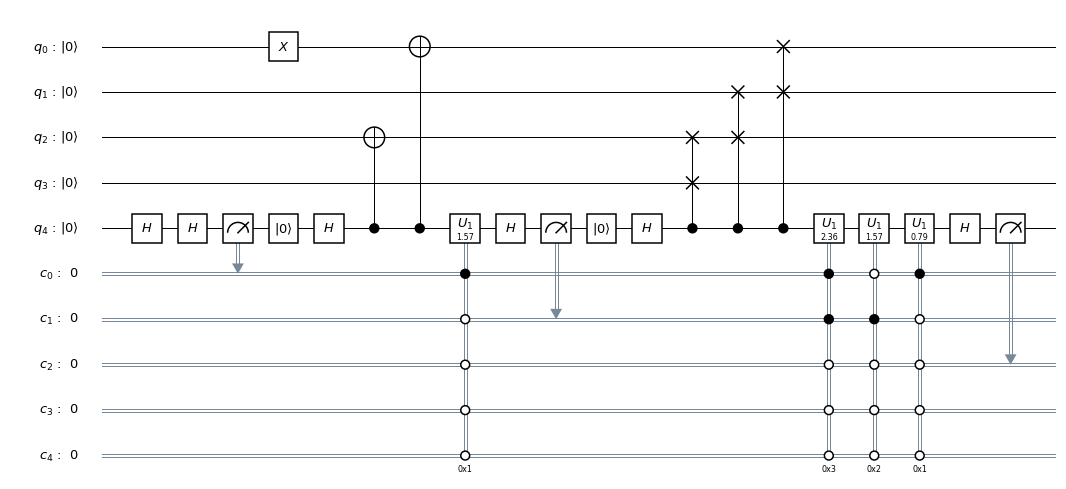

In [16]:
q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

shor = QuantumCircuit(q, c)
circuit_aperiod15(shor,q,c,2)
shor.draw(output='mpl')

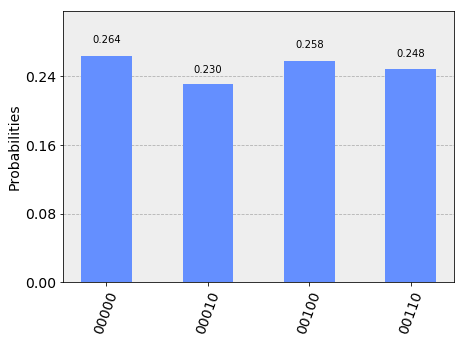

In [17]:
backend = BasicAer.get_backend('qasm_simulator')
sim_job = execute([shor], backend)
sim_result = sim_job.result()
sim_data = sim_result.get_counts(shor) 
plot_histogram(sim_data)

We can see that the measurements give x = 0, 2, 4, 6 with equal probability (with some noise, of course). In general at this point we can use the continued fraction expansion for ${\frac{x}{2^k}}$, but in this case r divides q, so there is no need to do so. We can simply compute ${p = GCD(a^{r/2} + 1, 15) = 5}$ and ${q = GCD(a^{r/2} - 1, 15) = 3}$.